Yiting Wang 4646909520

(a)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np, pandas as pd 
data = pd.read_table('../data/wdbc.data', sep=',', header = None)
data.columns = ['ID','class'] + ['feat%d'%i for i in range(1, data.shape[1] - 1)]
data.replace({'B' : 0, 'M' : 1}, inplace = True)

In [4]:
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

#Normalize the data
from sklearn import preprocessing
norm_X = pd.DataFrame(preprocessing.normalize(X))
data = pd.concat([y, norm_X], axis = 1)

In [5]:
#Split the benign and malignant class
benign, malignant = [],[]
for i in range(len(data)):
    if data['class'][i] == 0:
        benign.append(data.iloc[i,:])
    else:
        malignant.append(data.iloc[i,:])

benign = pd.DataFrame(benign)
malignant = pd.DataFrame(malignant)

In [6]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, KFold

L1_SVM = LinearSVC(penalty = 'l1', dual = False)
C_range = np.logspace(-1, 4, 8)
L1_params = {'C':C_range}
L1_grid = GridSearchCV(L1_SVM, L1_params, cv = KFold(5))

b(i)

In [1]:
def SVM_result(X, y, L1_SVM, best_C_list, accuracy_list, recall_list, precision_list, f1_list, AUC_list): 
    
    #Best SVM Penalty
    best_params = L1_SVM.best_params_
    best_C = best_params['C']
    best_C_list.append(best_C)
    
    #Accuracy
    y_pred = L1_SVM.predict(X)
    accuracy = accuracy_score(y_pred, y)
    accuracy_list.append(accuracy)
    
    #Precision
    precision = precision_score(y, y_pred)
    precision_list.append(precision)
    
    #Recall
    recall = recall_score(y, y_pred)
    recall_list.append(recall)
    
    #F1 score
    f1 = f1_score(y, y_pred)
    f1_list.append(f1)
    
    #AUC value
    clf = CalibratedClassifierCV(L1_SVM).fit(X, y)
    pred_proba = clf.predict_proba(X)[::,1]
    AUC_score = roc_auc_score(y, pred_proba)
    AUC_list.append(AUC_score)
    
    return best_C_list, accuracy_list, recall_list, precision_list, f1_list, AUC_list

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

best_C_train_list, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = [],[],[],[],[],[]
best_C_test_list, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = [],[],[],[],[],[]

for t in range(30):
    #Construct train_data, test_data
    train_benign, test_benign = train_test_split(benign, test_size = 0.2)
    train_malignant, test_malignant = train_test_split(malignant, test_size = 0.2)
    
    train_data = pd.concat([train_benign, train_malignant])
    test_data = pd.concat([test_benign, test_malignant])
    
    #Construct X_train, y_train, X_test, y_test
    X_train = train_data.iloc[:, 1:]
    y_train = train_data.iloc[:, 0]

    X_test = test_data.iloc[:, 1:]
    y_test = test_data.iloc[:, 0]
    
    #Construct the model
    L1_SVM = L1_grid.fit(X_train, y_train)
    best_C_train_list, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = SVM_result(X_train, y_train, L1_SVM, best_C_train_list, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list)
    
    best_C_test_list, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = SVM_result(X_test, y_test, L1_SVM, best_C_test_list, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list)

In [8]:
print('Train Data:')

best_C_train = np.mean(best_C_train_list)
best_C_train = round(best_C_train, 4)
print('Best SVM Penalty:', best_C_train)

accuracy_train = np.mean(accuracy_train_list)
accuracy_train = round(accuracy_train, 4)
print('Accuracy:', accuracy_train)

recall_train = np.mean(recall_train_list)
recall_train = round(recall_train, 4)
print('Recall:', recall_train)

precision_train = np.mean(precision_train_list)
precision_train = round(precision_train, 4)
print('Precision:', precision_train)

f1_train = np.mean(f1_train_list)
f1_train = round(f1_train, 4)
print('F1 score:', f1_train)

AUC_train = np.mean(AUC_train_list)
AUC_train = round(AUC_train, 4)
print('AUC score:', AUC_train)

Train Data:
Best SVM Penalty: 8655.1163
Accuracy: 0.9833
Recall: 0.9696
Precision: 0.9854
F1 score: 0.9774
AUC score: 0.9984


Confusion Matrix of Train Data:
[[284   1]
 [  7 162]]


No handles with labels found to put in legend.


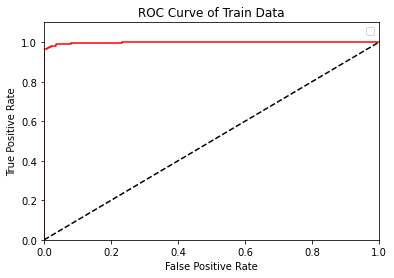

In [9]:
L1_SVM = L1_grid.fit(X_train, y_train)

#Confusion Matrix
y_pred = L1_SVM.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print('Confusion Matrix of Train Data:')
print(confusion_matrix(y_train, y_pred))

#ROC Curve
clf = CalibratedClassifierCV(L1_SVM).fit(X_train, y_train)
pred_proba = clf.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Train Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

In [10]:
print('Test Data:')

best_C_test = np.mean(best_C_test_list)
best_C_test = round(best_C_test, 4)
print('Best SVM Penalty:', best_C_test)

accuracy_test = np.mean(accuracy_test_list)
accuracy_test = round(accuracy_test, 4)
print('Accuracy:', accuracy_test)

recall_test = np.mean(recall_test_list)
recall_test = round(recall_test, 4)
print('Recall:', recall_test)

precision_test = np.mean(precision_test_list)
precision_test = round(precision_test, 4)
print('Precision:', precision_test)

f1_test = np.mean(f1_test_list)
f1_test = round(f1_test, 4)
print('F1 score:', f1_test)

AUC_test = np.mean(AUC_test_list)
AUC_test = round(AUC_test, 4)
print('AUC score:', AUC_test)

Test Data:
Best SVM Penalty: 8655.1163
Accuracy: 0.9646
Recall: 0.9442
Precision: 0.9613
F1 score: 0.952
AUC score: 0.9973


Confusion Matrix of Test Data:
[[72  0]
 [ 0 43]]


No handles with labels found to put in legend.


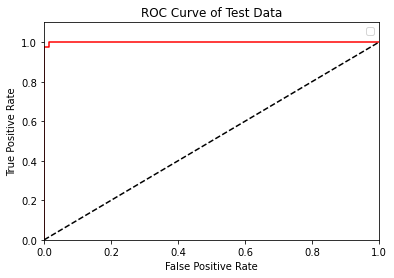

In [11]:
L1_SVM = L1_grid.fit(X_test, y_test)

#Confusion Matrix
y_pred = L1_SVM.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix of Test Data:')
print(confusion_matrix(y_test, y_pred))

#ROC Curve
clf = CalibratedClassifierCV(L1_SVM).fit(X_test, y_test)
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Test Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

b(ii) 

In [12]:
best_C_train_list, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = [],[],[],[],[],[]
best_C_test_list, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = [],[],[],[],[],[]

for t in range(30):
    
    #A
    #Construct train_data, test_data
    train_benign, test_benign = train_test_split(benign, test_size = 0.2)
    train_malignant, test_malignant = train_test_split(malignant, test_size = 0.2)
    
    train_data = pd.concat([train_benign, train_malignant])
    test_data = pd.concat([test_benign, test_malignant])
    
    #Construct X_train, y_train, X_test, y_test
    X_train = train_data.iloc[:, 1:]
    y_train = train_data.iloc[:, 0]

    X_test = test_data.iloc[:, 1:]
    y_test = test_data.iloc[:, 0]
    
    #Construct train_data, test_data
    labeled_data, unlabeled_data = train_test_split(train_data, test_size = 0.5)
    
    #Construct X_label, y_label, X_unlabel, y_unlabel
    X_label = labeled_data.iloc[:, 1:]
    y_label = labeled_data.iloc[:, 0]
    X_unlabel = unlabeled_data.iloc[:, 1:]
    y_unlabel = unlabeled_data.iloc[:, 0]
    
    #Construct the model
    L1_SVM = L1_grid.fit(X_label, y_label)
    
    #B
    while len(X_unlabel) > 0:
        
        #Calculate distance from unlabeled data points to decision boundary
        distances = L1_SVM.decision_function(X_unlabel)

        #Sort by the absolute value of score
        sorted_index = sorted([i for i in range(len(X_unlabel))], key = lambda x : abs(distances[x]), reverse = True)
        farthest_point = sorted_index[0]
        farthest_X = pd.DataFrame(X_unlabel.iloc[farthest_point,:])
        farthest_y = pd.Series(y_unlabel.iloc[farthest_point])
        
        #Remove the farest point from unlabeled and add it to labeled
        X_label = pd.concat([X_label, farthest_X.T])
        y_label = pd.concat([y_label, farthest_y])
        droped_index = X_unlabel.index[farthest_point]
        X_unlabel = X_unlabel.drop(index = droped_index)
        
        #Refit the SVC
        L1_SVM = L1_grid.fit(X_label, y_label)
    
    best_C_train_list, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = SVM_result(X_label, y_label, L1_SVM, best_C_train_list, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list)
    best_C_test_list, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = SVM_result(X_test, y_test, L1_SVM, best_C_test_list, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list)

In [13]:
print('Train Data:')

best_C_train = np.mean(best_C_train_list)
best_C_train = round(best_C_train, 4)
print('Best SVM Penalty:', best_C_train)

accuracy_train = np.mean(accuracy_train_list)
accuracy_train = round(accuracy_train, 4)
print('Accuracy:', accuracy_train)

recall_train = np.mean(recall_train_list)
recall_train = round(recall_train, 4)
print('Recall:', recall_train)

precision_train = np.mean(precision_train_list)
precision_train = round(precision_train, 4)
print('Precision:', precision_train)

f1_train = np.mean(f1_train_list)
f1_train = round(f1_train, 4)
print('F1 score:', f1_train)

AUC_train = np.mean(AUC_train_list)
AUC_train = round(AUC_train, 4)
print('AUC score:', AUC_train)

Train Data:
Best SVM Penalty: 2729.1925
Accuracy: 0.749
Recall: 0.5483
Precision: 0.6959
F1 score: 0.6126
AUC score: 0.7397


Confusion Matrix of Train Data:
[[285   0]
 [ 40 129]]


No handles with labels found to put in legend.


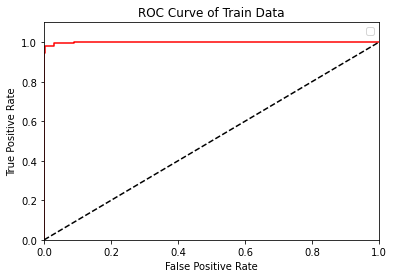

In [14]:
#Confusion Matrix
y_pred = L1_SVM.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print('Confusion Matrix of Train Data:')
print(confusion_matrix(y_train, y_pred))

#ROC Curve
clf = CalibratedClassifierCV(L1_SVM).fit(X_train, y_train)
pred_proba = clf.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Train Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

In [15]:
print('Test Data:')

best_C_test = np.mean(best_C_test_list)
best_C_test = round(best_C_test, 4)
print('Best SVM Penalty:', best_C_test)

accuracy_test = np.mean(accuracy_test_list)
accuracy_test = round(accuracy_test, 4)
print('Accuracy:', accuracy_test)

recall_test = np.mean(recall_test_list)
recall_test = round(recall_test, 4)
print('Recall:', recall_test)

precision_test = np.mean(precision_test_list)
precision_test = round(precision_test, 4)
print('Precision:', precision_test)

f1_test = np.mean(f1_test_list)
f1_test = round(f1_test, 4)
print('F1 score:', f1_test)

AUC_test = np.mean(AUC_test_list)
AUC_test = round(AUC_test, 4)
print('AUC score:', AUC_test)

Test Data:
Best SVM Penalty: 2729.1925
Accuracy: 0.9064
Recall: 0.7659
Precision: 0.981
F1 score: 0.8575
AUC score: 0.9981


Confusion Matrix of Test Data:
[[72  0]
 [ 8 35]]


No handles with labels found to put in legend.


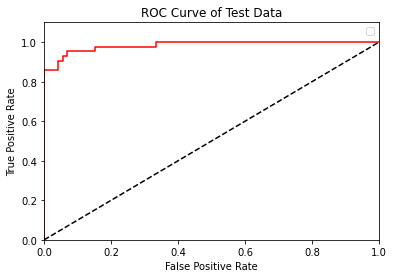

In [16]:
#Confusion Matrix
y_pred = L1_SVM.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Confusion Matrix of Test Data:')
print(confusion_matrix(y_test, y_pred))

#ROC Curve
clf = CalibratedClassifierCV(L1_SVM).fit(X_test, y_test)
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Test Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

b(iii)

A. Given kmeans iterative nature and the random initialization of centroids at the start of the algorithm, different initializations may lead to different clusters since kmeans algorithm may stuck in a local optimum and may not converge to global optimum. Therefore, it is better to run the algorithm using different initializations of centroids and pick the results of the run that that yielded the lower sum of squared distance.

In [32]:
def kmeans_result(X, y, y_pred, k_means, accuracy_list, recall_list, precision_list, f1_list, AUC_list): 
    
    #Accuracy
    accuracy = accuracy_score(y, y_pred)
    accuracy_list.append(accuracy)
    
    #Precision
    precision = precision_score(y, y_pred)
    precision_list.append(precision)
    
    #Recall
    recall = recall_score(y, y_pred)
    recall_list.append(recall)
    
    #F1 score
    f1 = f1_score(y, y_pred)
    f1_list.append(f1)
    
    #AUC value
    clf = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = kmeans.cluster_centers_).fit(X)
    pred_proba = clf.predict_proba(X)[::,1]
    AUC_score = roc_auc_score(y, pred_proba)
    AUC_list.append(AUC_score)
    
    
    return accuracy_list, recall_list, precision_list, f1_list, AUC_list

In [24]:
import operator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import euclidean_distances

accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = [], [], [], [], []
accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = [], [], [], [], []
cluster_majority = []

for t in range(30):
    
    #A
    #Construct train_data, test_data
    train_benign, test_benign = train_test_split(benign, test_size = 0.2)
    train_malignant, test_malignant = train_test_split(malignant, test_size = 0.2)
    
    train_data = pd.concat([train_benign, train_malignant])
    test_data = pd.concat([test_benign, test_malignant])
    
    #Construct X_train, y_train, X_test, y_test
    X_train = train_data.iloc[:, 1:]
    y_train = train_data.iloc[:, 0]

    X_test = test_data.iloc[:, 1:]
    y_test = test_data.iloc[:, 0]
    
    #Construct the model
    k_means = KMeans(n_clusters = 2, init = 'random').fit(X_train)    # build kmeans cluster with optimal k
    
    #B
    cluster_center = k_means.cluster_centers_
    y_pred_train = k_means.predict(X_train)
    distances = euclidean_distances(X_train, cluster_center)

    cluster1_distance, cluster2_distance = {},{}
    for i in range(len(X_train)):
        cluster1_distance[i] = distances[i][0]
        cluster2_distance[i] = distances[i][1]
    sorted_cluster1 = sorted(cluster1_distance.items(), key = operator.itemgetter(1))
    sorted_cluster2 = sorted(cluster2_distance.items(), key = operator.itemgetter(1))
    
    #Find the Majority of First Cluster 
    cluster1_label = {}
    for i in range(0, 30):
        index = sorted_cluster1[i][0]
        label = y[index]
        if label in cluster1_label.keys():
            cluster1_label[label] += 1
        else:
            cluster1_label[label] = 1
            
    sorted_cluster1_label = sorted(cluster1_label.items(), key = operator.itemgetter(1), reverse = True)
    cluster1_majority = sorted_cluster1_label[0][0]
    
    #Find the Majority of Second Cluster
    cluster2_label = {}
    for i in range(0, 30):
        index = sorted_cluster2[i][0]
        label = y[index]
        if label in cluster2_label.keys():
            cluster2_label[label] += 1
        else:
            cluster2_label[label] = 1
            
    sorted_cluster2_label = sorted(cluster2_label.items(), key = operator.itemgetter(1), reverse = True)
    cluster2_majority = sorted_cluster2_label[0][0]
    
    cluster_majority.append(cluster1_majority)
    cluster_majority.append(cluster2_majority)
    
    accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = cluster_result(X_train, y_train, y_pred_train, k_means, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list)
    
    #C
    #Test Data
    y_pred_test = k_means.predict(X_test)
    accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = cluster_result(X_test, y_test, y_pred_test, k_means, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list)

In [25]:
print('Train Data:')

accuracy_train = np.mean(accuracy_train_list)
accuracy_train = round(accuracy_train, 4)
print('Accuracy:', accuracy_train)

recall_train = np.mean(recall_train_list)
recall_train = round(recall_train, 4)
print('Recall:', recall_train)

precision_train = np.mean(precision_train_list)
precision_train = round(precision_train, 4)
print('Precision:', precision_train)

f1_train = np.mean(f1_train_list)
f1_train = round(f1_train, 4)
print('F1 score:', f1_train)

AUC_train = np.mean(AUC_train_list)
AUC_train = round(AUC_train, 4)
print('AUC score:', AUC_train)

Train Data:
Accuracy: 0.5764
Recall: 0.5406
Precision: 0.6326
F1 score: 0.5682
AUC score: 0.5936


No handles with labels found to put in legend.


Confusion Matrix of Train Data:
[[282   3]
 [ 47 122]]


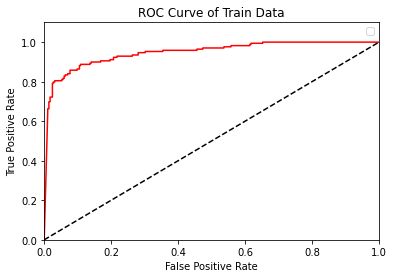

In [28]:
#Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
print('Confusion Matrix of Train Data:')
print(confusion_matrix(y_train, y_pred_train))

#ROC Curve
clf = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = k_means.cluster_centers_).fit(X_train)
pred_proba = clf.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Train Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

In [29]:
print('Test Data:')

accuracy_test = np.mean(accuracy_test_list)
accuracy_test = round(accuracy_test, 4)
print('Accuracy:', accuracy_test)

recall_test = np.mean(recall_test_list)
recall_test = round(recall_test, 4)
print('Recall:', recall_test)

precision_test = np.mean(precision_test_list)
precision_test = round(precision_test, 4)
print('Precision:', precision_test)

f1_test = np.mean(f1_test_list)
f1_test = round(f1_test, 4)
print('F1 score:', f1_test)

AUC_test = np.mean(AUC_test_list)
AUC_test = round(AUC_test, 4)
print('AUC score:', AUC_test)

Test Data:
Accuracy: 0.5788
Recall: 0.5558
Precision: 0.6243
F1 score: 0.5743
AUC score: 0.5973


No handles with labels found to put in legend.


Confusion Matrix of Test Data:
[[69  3]
 [14 29]]


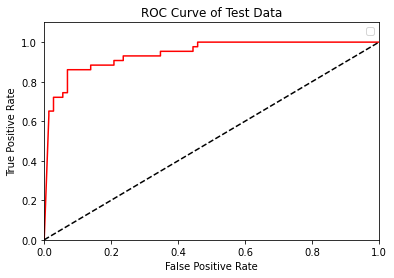

In [30]:
#Confusion Matrix
y_pred = L1_SVM.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
print('Confusion Matrix of Test Data:')
print(confusion_matrix(y_test, y_pred_test))

#ROC Curve
clf = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = k_means.cluster_centers_).fit(X_test)
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Test Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

The average scores of accuracy, precision, recall, F1-score, and AUC in the Supervised Learning is much more than those in the other two  algorithms. The average scores of accuracy, precision, recall, F1-score, and AUC in Semi-Supervised Learning are slightly more than those in the Unsupervised Learning.

b(iv)

Spectral clustering is a technique with roots in graph theory, where the approach is used to identify communities of nodes in a graph based on the edges connecting them. The method is flexible and allows us to cluster non graph data as well.

In [34]:
def spectral_result(X, y, y_pred, k_means, accuracy_list, recall_list, precision_list, f1_list, AUC_list): 
    
    #Accuracy
    accuracy = accuracy_score(y, y_pred)
    accuracy_list.append(accuracy)
    
    #Precision
    precision = precision_score(y, y_pred)
    precision_list.append(precision)
    
    #Recall
    recall = recall_score(y, y_pred)
    recall_list.append(recall)
    
    #F1 score
    f1 = f1_score(y, y_pred)
    f1_list.append(f1)
    
    #AUC value
    clf = GaussianMixture(n_components = 2, covariance_type = 'spherical').fit(X)
    pred_proba = clf.predict_proba(X)[::,1]
    AUC_score = roc_auc_score(y, pred_proba)
    AUC_list.append(AUC_score)
    
    return accuracy_list, recall_list, precision_list, f1_list, AUC_list

In [36]:
from sklearn.cluster import SpectralClustering
accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = [], [], [], [], []
accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = [], [], [], [], []

for t in range(30):
    
    #Construct train_data, test_data
    train_benign, test_benign = train_test_split(benign, test_size = 0.2)
    train_malignant, test_malignant = train_test_split(malignant, test_size = 0.2)
    
    train_data = pd.concat([train_benign, train_malignant])
    test_data = pd.concat([test_benign, test_malignant])
    
    #Construct X_train, y_train, X_test, y_test
    X_train = train_data.iloc[:, 1:]
    y_train = train_data.iloc[:, 0]

    X_test = test_data.iloc[:, 1:]
    y_test = test_data.iloc[:, 0]
    
    #Construct the model
    spectral_cluster = SpectralClustering(n_clusters = 2, gamma = 1.0, eigen_tol = 1.0, assign_labels ='discretize')
    labels_train = spectral_cluster.fit_predict(X_train)
    
    accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list = spectral_result(X_train, y_train, labels_train, spectral_cluster, accuracy_train_list, recall_train_list, precision_train_list, f1_train_list, AUC_train_list)
    
    #Test Data
    labels_test = spectral_cluster.fit_predict(X_test)
    accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list = spectral_result(X_test, y_test, labels_test, spectral_cluster, accuracy_test_list, recall_test_list, precision_test_list, f1_test_list, AUC_test_list)

In [37]:
print('Train Data:')

accuracy_train = np.mean(accuracy_train_list)
accuracy_train = round(accuracy_train, 4)
print('Accuracy:', accuracy_train)

recall_train = np.mean(recall_train_list)
recall_train = round(recall_train, 4)
print('Recall:', recall_train)

precision_train = np.mean(precision_train_list)
precision_train = round(precision_train, 4)
print('Precision:', precision_train)

f1_train = np.mean(f1_train_list)
f1_train = round(f1_train, 4)
print('F1 score:', f1_train)

AUC_train = np.mean(AUC_train_list)
AUC_train = round(AUC_train, 4)
print('AUC score:', AUC_train)

Train Data:
Accuracy: 0.5253
Recall: 0.5164
Precision: 0.5281
F1 score: 0.5159
AUC score: 0.6227


No handles with labels found to put in legend.


Confusion Matrix of Train Data:
[[282   3]
 [ 47 122]]


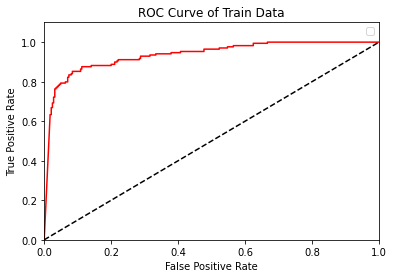

In [38]:
#Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
print('Confusion Matrix of Train Data:')
print(confusion_matrix(y_train, y_pred_train))

#ROC Curve
clf = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = k_means.cluster_centers_).fit(X_train)
pred_proba = clf.predict_proba(X_train)[::,1]
fpr, tpr, _ = roc_curve(y_train, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Train Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

In [39]:
print('Test Data:')

accuracy_test = np.mean(accuracy_test_list)
accuracy_test = round(accuracy_test, 4)
print('Accuracy:', accuracy_test)

recall_test = np.mean(recall_test_list)
recall_test = round(recall_test, 4)
print('Recall:', recall_test)

precision_test = np.mean(precision_test_list)
precision_test = round(precision_test, 4)
print('Precision:', precision_test)

f1_test = np.mean(f1_test_list)
f1_test = round(f1_test, 4)
print('F1 score:', f1_test)

AUC_test = np.mean(AUC_test_list)
AUC_test = round(AUC_test, 4)
print('AUC score:', AUC_test)

Test Data:
Accuracy: 0.6319
Recall: 0.6
Precision: 0.6397
F1 score: 0.6132
AUC score: 0.561


No handles with labels found to put in legend.


Confusion Matrix of Test Data:
[[69  3]
 [14 29]]


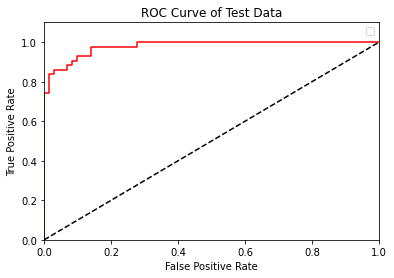

In [40]:
#Confusion Matrix
y_pred = L1_SVM.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
print('Confusion Matrix of Test Data:')
print(confusion_matrix(y_test, y_pred_test))

#ROC Curve
clf = GaussianMixture(n_components = 2, covariance_type = 'spherical', means_init = k_means.cluster_centers_).fit(X_test)
pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, pred_proba)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Test Data')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

b(v)

According to the scores of accuracy, precision, recall, F1-score and AUC, supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled. Unsupervised learning underperforms in such situations.